In [1]:
import torch
import math
import numpy as np
import easydict
import argparse
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from utils.data_loader import TextLoader
from backbone.model_builder import BertSeparator

In [2]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [3]:
parser = argparse.ArgumentParser()
#parser.add_argument('--task', default='ext', type=str, choices=['ext', 'abs'])
parser.add_argument('--encoder', default='bert', type=str, choices=['bert', 'baseline'])
parser.add_argument('--backbone_type', default='bert', type=str, choices=['bert', 'bertsum'])
parser.add_argument('--classifier_type', default='conv', type=str, choices=['conv', 'linear'])
parser.add_argument('--mode', default='train', type=str, choices=['train', 'test'])
parser.add_argument('--random_seed', default=227182, type=int)

# Model builder
# parser.add_argument('--mode', default='train', type=str, choices=['train', 'validate', 'test'])

#parser.add_argument('--bert_data_path', default='../bert_data_new/cnndm')
parser.add_argument('--model_index', default='A01', type=str)
parser.add_argument('--dataset_path', default='dataset/')
parser.add_argument('--model_path', default='models/')
parser.add_argument('--result_path', default='results')
parser.add_argument('--temp_dir', default='temp/')

# dataset type
parser.add_argument('--data_type', default='bfly', type=str)
parser.add_argument('--window_size', default=3, type=int)
#parser.add_argument('--y_ratio', default=0.5, type=float)
parser.add_argument('--use_stair', action='store_true')
parser.add_argument('--random_point', action='store_true')

parser.add_argument('--batch_size', default=3000, type=int)
parser.add_argument('--test_batch_size', default=200, type=int)

parser.add_argument('--max_pos', default=512, type=int)
parser.add_argument('--use_interval', type=str2bool, nargs='?', const=True, default=True)
parser.add_argument('--large', type=str2bool, nargs='?', const=True, default=False)
parser.add_argument('--load_from_extractive', default='', type=str)

parser.add_argument('--sep_optim', type=str2bool, nargs='?',const=True,default=False)
parser.add_argument('--lr_bert', default=2e-3, type=float)
parser.add_argument('--lr_dec', default=2e-3, type=float)
parser.add_argument('--use_bert_emb', type=str2bool, nargs='?',const=True,default=False)

parser.add_argument('--share_emb', type=str2bool, nargs='?', const=True, default=False)
parser.add_argument('--finetune_bert', type=str2bool, nargs='?', const=True, default=True)
parser.add_argument('--dec_dropout', default=0.2, type=float)
parser.add_argument('--dec_layers', default=6, type=int)
parser.add_argument('--dec_hidden_size', default=768, type=int)
parser.add_argument('--dec_heads', default=8, type=int)
parser.add_argument('--dec_ff_size', default=2048, type=int)
parser.add_argument('--enc_hidden_size', default=512, type=int)
parser.add_argument('--enc_ff_size', default=512, type=int)
parser.add_argument('--enc_dropout', default=0.2, type=float)
parser.add_argument('--enc_layers', default=6, type=int)

# params for sep layers
# !!TODO!! change ext -> sep
parser.add_argument('--add_transformer', type=str2bool, nargs='?', const=True, default=True)
parser.add_argument('--ext_dropout', default=0.2, type=float)
parser.add_argument('--ext_layers', default=2, type=int)
parser.add_argument('--ext_hidden_size', default=768, type=int)
parser.add_argument('--ext_heads', default=8, type=int)
parser.add_argument('--ext_ff_size', default=2048, type=int)

parser.add_argument('--label_smoothing', default=0.1, type=float)
parser.add_argument('--generator_shard_size', default=32, type=int)
parser.add_argument('--alpha',  default=0.6, type=float)
parser.add_argument('--beam_size', default=5, type=int)
parser.add_argument('--min_length', default=15, type=int)
parser.add_argument('--max_length', default=150, type=int)
parser.add_argument('--max_tgt_len', default=140, type=int)

parser.add_argument('--param_init', default=0, type=float)
parser.add_argument('--param_init_glorot', type=str2bool, nargs='?',const=True,default=True)
parser.add_argument('--optim', default='adam', type=str)
parser.add_argument('--lr', default=0.0001, type=float)
parser.add_argument('--beta1', default= 0.9, type=float)
parser.add_argument('--beta2', default=0.999, type=float)
parser.add_argument('--warmup_steps', default=1000, type=int)
parser.add_argument('--warmup_steps_bert', default=8000, type=int)
parser.add_argument('--warmup_steps_dec', default=8000, type=int)
parser.add_argument('--max_grad_norm', default=0, type=float)

parser.add_argument('--save_checkpoint_steps', default=500, type=int)
parser.add_argument('--accum_count', default=1, type=int)
parser.add_argument('--report_every', default=10, type=int)
parser.add_argument('--train_steps', default=10000, type=int)
parser.add_argument('--recall_eval', type=str2bool, nargs='?',const=True,default=False)
parser.add_argument('--valid_steps', default=500, type=int)

parser.add_argument('--visible_gpus', default='1', type=str)
parser.add_argument('--gpu_ranks', default='0', type=str)
parser.add_argument('--log_dir', default='logs/traineval')

# Eval
# !!TODO!! test_from 바꾸기
parser.add_argument('--test_mode', default='cls', type=str, help="[cls, sep]")
parser.add_argument('--test_max_mode', default='max_all', type=str, help="[max_all, sep]")
parser.add_argument('--compare_window', type=str2bool, nargs='?', const=True, default=False)
parser.add_argument('--test_sep_num', default=2000, type=int)
parser.add_argument('--test_all', type=str2bool, nargs='?',const=True,default=False)
parser.add_argument('--test_from', default='models/model_w3_fixed_step_50000.pt')
parser.add_argument('--test_start_from', default=-1, type=int)
parser.add_argument('--threshold', default=0.5, type=float)

parser.add_argument('--train_from', default='')
parser.add_argument('--report_rouge', type=str2bool, nargs='?',const=True,default=True)
parser.add_argument('--block_trigram', type=str2bool, nargs='?', const=True, default=True)

_StoreAction(option_strings=['--block_trigram'], dest='block_trigram', nargs='?', const=True, default=True, type=<function str2bool at 0x7fe7442c4940>, choices=None, help=None, metavar=None)

In [4]:
args = parser.parse_args(args=[])

In [5]:
# hyper-params
args.add_transformer = False

# Cosine Similarity

In [9]:
checkpoint = torch.load('models/index_NB03/model_w3_fixed_step_100000.pt', map_location='cpu')
model = BertSeparator(args, 'cpu', None)

using cached model
using cached model
using cached model


In [10]:
checkpoint = torch.load('models/index_NB03/model_w3_fixed_step_70000.pt', map_location='cpu')

In [11]:
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

BertSeparator(
  (bert): Bert(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(8004, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm

In [25]:
doc = '''
대한민국 제13대 대통령을 지낸 노태우 전 대통령이 26일 숨졌다.
지병으로 오랜 병상 생활을 해온 노 전 대통령은 최근 병세 악화로 서울대병원에 입원, 의료진의 집중 치료를 받았지만, 끝내 회복하지 못하고 삶을 마감했다.
1932년 12월4일 경북 달성군 공산면 신용리(현 대구 동구 신용동)에서 면 서기였던 아버지 노병수와 어머니 김태향의 장남으로 태어난 노 전 대통령은 경북고와 육군사관학교를 졸업하고 보안사령관, 체육부·내무부 장관, 12대 국회의원, 민주정의당 대표를 지냈다.
한국체육대학교(총장 안용규), 숙명여자대학교(총장 장윤금) 및 한국스포츠정책과학원(원장 남윤신)은 27일 한국체육대학교에서 ‘스포츠 ODA(공적개발원조) 전문인력 양성을 위한 콜로키엄’을 개최한다.
콜로키엄은 온·오프라인으로 동시 운영되며, 전 과정이 한국체육대학교 유튜브 채널를 통해 중계된다.
이번 콜로키엄은 청소년과 여성의 역량강화를 통한 스포츠 ODA 방안을 모색하고, 저개발국가의 스포츠 전문인력 양성의 토대를 마련해 스포츠의 가치를 확산한다는 취지로 열린다.
'''

In [78]:
doc = '''
문화체육관광부는 지난해 11월 중단한 숙박·여행·공연·전시·영화·실내체육시설·프로스포츠 7개 분야 소비할인권 사용을 내달 단계적 일상 회복 시점부터 재개한다고 26일 밝혔다.
문화 활동과 소비를 회복하고 코로나로 피해를 본 업계를 지원하려는 조처다.
숙박 분야에선 온라인 예약 시 7만 원 이하 숙박은 2만 원, 7만 원 초과 숙박은 3만 원을 할인한다.
일부 지자체와 협업해 7만 원 초과 숙박 시 5만 원 할인권도 7만 장 배포할 예정이다.
숙박 할인권은 국내 50여 개 온라인여행사(OTA) 누리집에서 신청할 수 있다.
여행 분야는 투어비스 누리집을 통해 해당 상품을 검색·예약할 수 있다. 공모를 통해 선정된 국내 여행상품 조기 예약 및 선결제 시 40%를 할인해 준다. 장애인과 국가유공자는 무료로 여행을 즐길 수 있다.
'''

doc = [doc.strip()]

In [12]:
valid = torch.load('dataset/bfly/bertsep_data/bertsep_dt_valid_w3_fixed.pt')
docs = ['\n'.join(v['src_txt']) for v in valid]
labels = [v['sep_label'] for v in valid]

In [13]:
# load text
textloader = TextLoader(args, 'cpu')

using cached model
using cached model


In [14]:
tmp_batch = textloader.load_text(doc)

NameError: name 'doc' is not defined

In [15]:
class BertsegResult:
    def __init__(self, payers, encoder_index):
        self.hook = payers.bert.model.encoder.layer[encoder_index].register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.output = output
    
    def unregister_forward_hook(self):
        self.hook.remove()
        
result_set = [BertsegResult(model, i) for i in range(12)]

In [16]:
def dist_calc(model, doc):
    def _get_cos_sim(vec_set):
        res = []
        for l in range(12):
            lm = torch.mean(cls_vec_set[l].squeeze(0).detach()[:3], dim=0)
            rm = torch.mean(cls_vec_set[l].squeeze(0).detach()[3:], dim=0)
            cos = torch.nn.functional.cosine_similarity(lm, rm, dim=0)
            res.append(round(cos.item(), 4))
        return res

    tmp_batch = textloader.load_text(doc)
    result_set = [BertsegResult(model, i) for i in range(12)]
    
    for i, batch in enumerate(tmp_batch):
        (src, segs, clss, mask_src, mask_cls), _ = batch
        output = model(src, segs, clss, mask_src, mask_cls)

    top_vec_set = [res.output[0] for res in result_set]
    cls_vec_set = [top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss] for top_vec in top_vec_set]
    
    res_cos = _get_cos_sim(cls_vec_set)
    return res_cos

In [17]:
docs = ['\n'.join(v['src_txt']) for v in valid]
labels = [v['sep_label'] for v in valid]

In [18]:
fin_res = []
for d, l in zip(docs[:100], labels[:100]):
    res_cos = dist_calc(model, d)
    fin_res.append([res_cos, l])

In [19]:
fin0 = [f[0] for f in fin_res if f[1] == 0]
fin1 = [f[0] for f in fin_res if f[1] == 1]

In [20]:
import numpy as np
import seaborn as sns

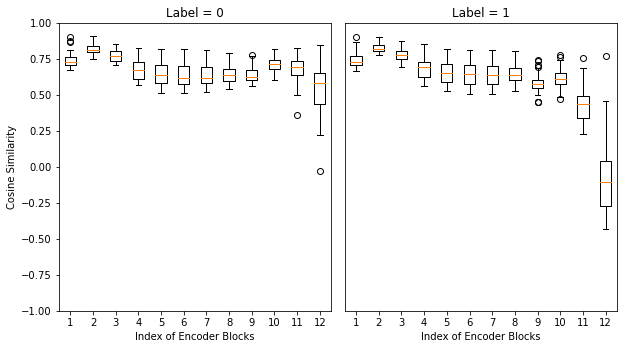

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

res = [fin0, fin1]
titles = ['Label = 0', 'Label = 1']

for i, ax in enumerate(axes):
    ax.set_ylim(-1, 1)
    ax.set_title(titles[i])
    ax.boxplot(np.array(res[i]))
    ax.set_xlabel('Index of Encoder Blocks')
    if i == 0:
        ax.set_ylabel('Cosine Similarity')
        
    if i == 1:
        ax.get_yaxis().set_visible(False)
        
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, wspace=0.05, hspace=0.2)
plt.savefig('boxplot.png')

# Gradient

In [39]:
# hyper-params
args.add_transformer = True

model = BertSeparator(args, 'cpu', None)

checkpoint = torch.load('models/index_D032/model_w3_fixed_step_100000.pt', map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

using cached model
using cached model
using cached model


BertSeparator(
  (bert): Bert(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(8004, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm

In [476]:
doc = '''
문화체육관광부는 지난해 11월 중단한 숙박 등 7개 분야 소비할인권 사용을 내달 재개한다고 26일 밝혔다.
문화 활동과 소비를 회복하고 코로나로 피해를 본 업계를 지원하려는 조처다.
숙박 분야에선 온라인 예약 시 7만 원 이하 숙박은 2만 원, 7만 원 초과 숙박은 3만 원을 할인한다.
현재 일부 경기 남부와 충청으로는 매우 나쁨 수준 보이고 있습니다.
오늘 경기 남부와 세종, 충북과 전북, 대구는 계속해서 나쁨 수준 보이겠고요.
북서풍이 불어들면서 오후에는 남부지방으로 먼지가 밀려나겠습니다.
'''

doc = [doc.strip()]

In [40]:
doc = '''
대한민국 제13대 대통령을 지낸 노태우 전 대통령이 26일 숨졌다.
지병으로 오랜 병상 생활을 해온 노 전 대통령은 최근 병세 악화로 끝내 회복하지 못하고 삶을 마감했다.
노 전 대통령은 경북고와 육군사관학교를 졸업하고 보안사령관, 체육부·내무부 장관, 12대 국회의원, 민주정의당 대표를 지냈다.
한국체육대학교(총장 안용규), 숙명여자대학교(총장 장윤금) 및 한국스포츠정책과학원(원장 남윤신)은 ‘스포츠 ODA(공적개발원조) 전문인력 양성을 위한 콜로키엄’을 개최한다.
콜로키엄은 온·오프라인으로 동시 운영되며, 전 과정이 한국체육대학교 유튜브 채널를 통해 중계된다.
이번 콜로키엄은 청소년과 여성의 역량강화를 통한 스포츠 ODA 방안을 모색하고, 저개발국가의 스포츠 전문인력 양성의 토대를 마련해 스포츠의 가치를 확산한다는 취지로 열린다.
'''

doc = [doc.strip()]

In [14]:
valid = torch.load('dataset/bfly/bertsep_data/bertsep_dt_valid_w3_fixed.pt')
docs = ['\n'.join(v['src_txt']) for v in valid]
labels = [v['sep_label'] for v in valid]

In [15]:
# load text
textloader = TextLoader(args, 'cpu')
tmp_batch = textloader.load_text(doc)

using cached model
using cached model


In [532]:
class BertsegResult:
    def __init__(self, payers, encoder_index):
        #self.hook = payers.bert.model.encoder.layer[encoder_index].register_forward_hook(self.hook_fn)
        self.hook = payers.bert.model.encoder.layer[encoder_index].register_backward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.output = output
    
    def unregister_forward_hook(self):
        self.hook.remove()
        
result_set = [BertsegResult(model, i) for i in range(12)]

In [533]:
for i, batch in enumerate(tmp_batch):
    (src, segs, clss, mask_src, mask_cls), _ = batch
    output = model(src, segs, clss, mask_src, mask_cls)

In [534]:
print(output)

tensor([7.6603], grad_fn=<ViewBackward>)


In [535]:
output.backward()

In [536]:
mean_result = [torch.mean(res.output[0].squeeze(0), dim=1).numpy() for res in result_set]
mean_np = np.array(mean_result)

In [537]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

scaled_mean_np = np.apply_along_axis(lambda a: min_max_scaler.fit_transform(a.reshape(-1, 1)), 1, mean_np).squeeze(-1)

<AxesSubplot:>

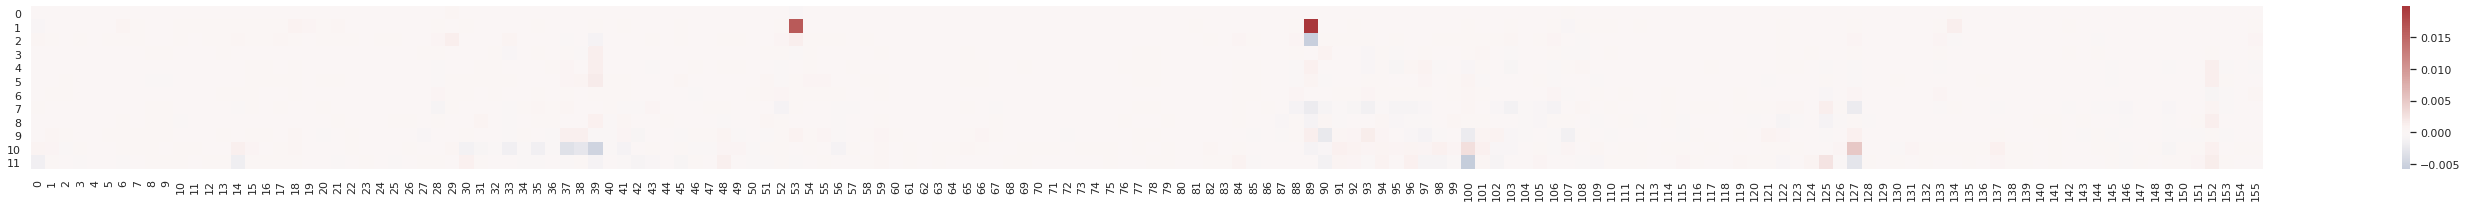

In [538]:
import numpy as np
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(50, 3))
sns.heatmap(mean_np[::-1], center=0.0, cmap = 'vlag')

<AxesSubplot:>

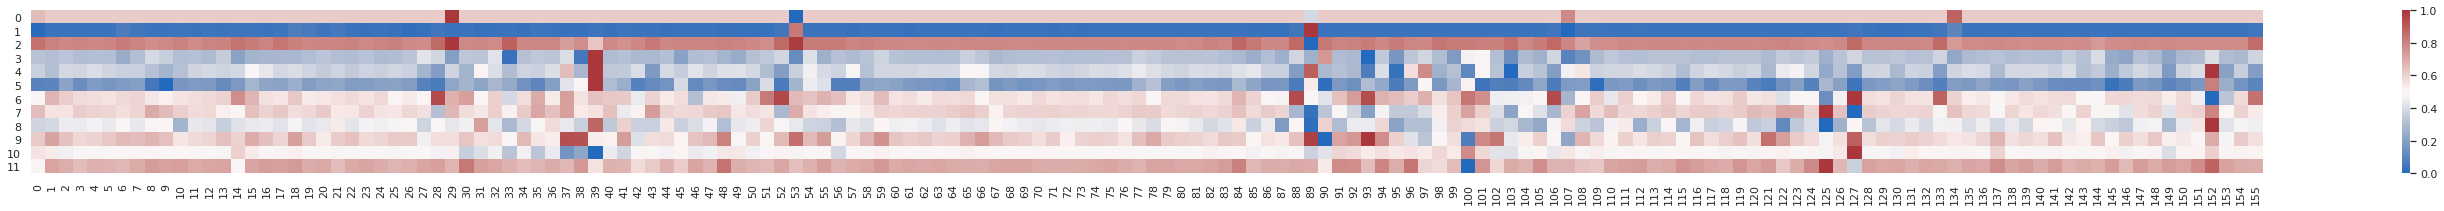

In [539]:
import numpy as np
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(50, 3))
sns.heatmap(scaled_mean_np[::-1], center=0.5, cmap='vlag')

In [397]:
top_vec = back_res.output[0]
grads = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss]

In [336]:
top_vec_set = [res.output[0] for res in result_set]
cls_vec_set = [top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss] for top_vec in top_vec_set]

# Attention Map

In [7]:
import gluonnlp as nlp
import matplotlib.pyplot as plt
import seaborn as sns
from kobert.utils import get_tokenizer, tokenizer
from kobert.utils import download as _download

In [8]:
args.add_transformer = False
args.classifier_type = 'conv'
args.window_size = 3

model = BertSeparator(args, 'cpu', None)

checkpoint = torch.load('models/index_NB03/model_w3_fixed_step_70000.pt', map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

using cached model
using cached model
using cached model


BertSeparator(
  (bert): Bert(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(8004, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm

In [9]:
doc = '''
정부는 백신 수급 상황은 충분히 개선돼 오히려 백신이 약간 여유 있는 상황이라고 밝혔습니다.
아스트라제네카 백신의 경우 2분기 도입 물량 중 106만여 회분이 내일 sk바이오사이언스 안동공장에서 출고됩니다.
일부 차질을 빚었던 화이자 백신 1차 접종도 이번 주말 전국예방접종센터에서 정상화될 예정입니다.
경미한 시설은 물론 병사들이 일상생활을 하는 생활관 거기에 출퇴근하는 간부들까지 동시에 감염이 이뤄져 감염 경로를 확인하기 어려운 상황입니다.
기존 집단 감염 확산도 계속되면서 부산 수영구 댄스 동호회 확진자는 16명 늘어 모두 40명까지 늘어났습니다.
경남 김해시의 외국인 모임 관련 확진자도 12명이 증가해 39명이 됐습니다.
'''

doc = [doc.strip()]

In [139]:
doc = '''
대한민국 제13대 대통령을 지낸 노태우 전 대통령이 26일 숨졌다.
지병으로 오랜 병상 생활을 해온 노 전 대통령은 최근 병세 악화로 끝내 회복하지 못하고 삶을 마감했다.
노 전 대통령은 경북고와 육군사관학교를 졸업하고 보안사령관, 체육부·내무부 장관, 12대 국회의원, 민주정의당 대표를 지냈다.
노태우 전 대통령의 생가는 전라북도에 위치해있으며, 장례식은 26일부터 치뤄질 예정이다.
한국체육대학교(총장 안용규), 숙명여자대학교(총장 장윤금) 및 한국스포츠정책과학원(원장 남윤신)은 ‘스포츠 ODA(공적개발원조) 전문인력 양성을 위한 콜로키엄’을 개최한다.
콜로키엄은 온·오프라인으로 동시 운영되며, 전 과정이 한국체육대학교 유튜브 채널를 통해 중계된다.
'''

doc = [doc.strip()]

In [12]:
doc = '''
대한민국 제13대 대통령을 지낸 노태우 전 대통령이 26일 숨졌다.
지병으로 오랜 병상 생활을 해온 노 전 대통령은 최근 병세 악화로 끝내 회복하지 못하고 삶을 마감했다.
한국체육대학교(총장 안용규), 숙명여자대학교(총장 장윤금) 및 한국스포츠정책과학원(원장 남윤신)은 ‘스포츠 ODA(공적개발원조) 전문인력 양성을 위한 콜로키엄’을 개최한다.
콜로키엄은 온·오프라인으로 동시 운영되며, 전 과정이 한국체육대학교 유튜브 채널를 통해 중계된다.
'''

doc = [doc.strip()]

In [915]:
doc = """
미얀마군이 반군부 세력의 무장 투쟁 강화에 병력 손실이 커지자 전역한 병사들까지 다시 군으로 끌어들이고 있는 것으로 알려졌다 강화에 병력 손실이 커지자 전역한 병사들까지 다시 군으로 끌어들이고
미얀마군은 기존의 연금을 보장하고, 전역 이전 계급으로 복무하면서 월급까지 받을 수 있다며 전역병들에게 재복무를 제안하고 있다고 한 전역병이 전했다 미얀마군은 기존의 연금을 보장하고, 전역 이전 계급으로 복무하면서 월급까지 받을 수 있다며 전역병들에게 재복무를 제안하고 있다고 한 전역병이 전했다.
이 제안은 60대에 들어선 전역자들에게도 가고 있다고 이 전역병은 덧붙였다  60대에 들어선 전역자들에게도 가고 있다고 이 전역병은 덧붙였다 60대에 들어선 전역자들에게도 가고 있다고 이 전역병은 덧붙였다
이와 관련, 중북부 사가잉 지역의 카따구의 경우에는 최소 50명의 전역자가 이미 재배치됐다고 그는 설명했다 다시 군으로 끌어들이고 있는 것으로 알려졌다 강화에 병력 손실이 커지자 전역한 병사들까지 다시 군으로 끌어들이고
사가잉 지역에서만 1천명 이상의 전직 군인들이 살고 있고, 카따구에도 200명가량이 생활하고 있는 것으로 알려졌다 다시 군으로 끌어들이고 있는 것으로 알려졌다 강화에 병력 손실이 커지자 전역한 병사들까지 다시 군으로 끌어들이고 사가잉 지역에서만 1천명 이상의 전직 군인들이 살고 있고, 카따구에도 200명가량이 생활하고 있는 것으로 알려졌다 다시 군으로 끌어들이고 있는 것으로 알려졌다 강화에 병력 손실이 커지자 전역한 병사들까지 다시 군으로 끌어들이고
전역자들을 상대로 한 재복무 사업은 군부의 최우선 임무 중 하나인 것으로 보인다고 매체는 전했다 전역자들을 상대로 한 재복무 사업은 군부의 최우선 임무 중 하나인 것으로 보인다고 매체는 전했다 전역자들을 상대로 한 재복무 사업은 군부의 최우선 임무 중 하나인 것으로 보인다고 매체는 전했다전역자들을 상대로 한 재복무 사업은 군부의 최우선 임무 중 하나인 것으로 보인다고 매체는 전했다
"""
doc = [doc.strip()]

In [96]:
# valid = torch.load('dataset/bfly/bertsep_data/bertsep_dt_valid_w3_fixed.pt')
# docs = ['\n'.join(v['src_txt']) for v in valid]
# labels = [v['sep_label'] for v in valid]

In [10]:
# load text
textloader = TextLoader(args, 'cpu')
tmp_batch = textloader.load_text(doc)

using cached model
using cached model


In [11]:
class BertsegResult:
    def __init__(self, payers, encoder_index):
        #self.hook = payers.bert.model.encoder.layer[encoder_index].register_forward_hook(self.hook_fn)
        payers.bert.model.encoder.layer[encoder_index].attention.self.query.register_forward_hook(self.hook_fn)
        payers.bert.model.encoder.layer[encoder_index].attention.self.key.register_forward_hook(self.hook_fn)
        self.qk_list = []
    
    def hook_fn(self, module, input, output):
        self.qk_list.append(output)
    
    def unregister_forward_hook(self):
        self.hook.remove()
        
result_set = [BertsegResult(model, i) for i in range(12)]

In [12]:
for i, batch in enumerate(tmp_batch):
    (src, segs, clss, mask_src, mask_cls), _ = batch
    output = model(src, segs, clss, mask_src, mask_cls)

In [13]:
print(output)

tensor([1.5449], grad_fn=<ViewBackward>)


In [144]:
qs = [res.qk_list[0] for res in result_set]
ks = [res.qk_list[1] for res in result_set]

<AxesSubplot:>

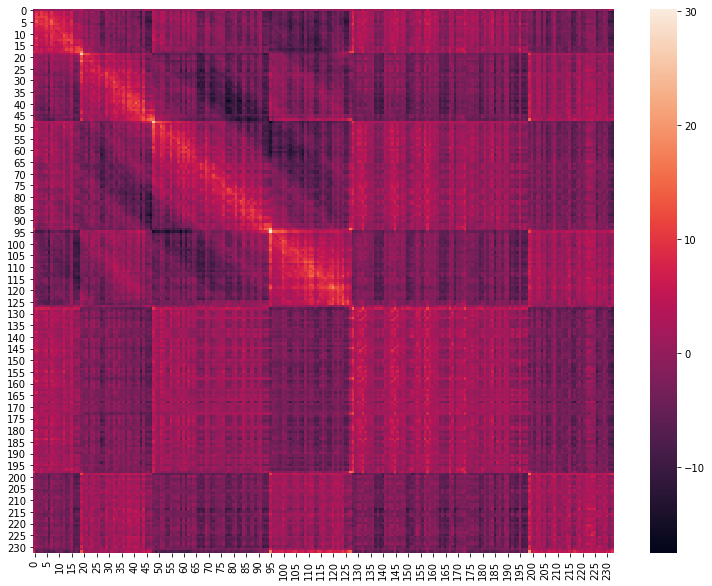

In [149]:
layer = 0

q, k = qs[layer], ks[layer]
new_q_shape = q.size()[:-1] + (8, 96)
new_k_shape = k.size()[:-1] + (8, 96)

q = q.view(*new_q_shape).permute(0, 2, 1, 3)
k = k.view(*new_k_shape).permute(0, 2, 1, 3)

attn_map = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(8)
attn_map = attn_map.detach().numpy()

head = 1
attn_map_head = np.mean(attn_map.squeeze(0), axis=0)

#sns.set_theme()
plt.figure(figsize=(13, 10))
sns.heatmap(attn_map_head)

In [147]:
clss

tensor([[  0,  19,  48,  95, 128, 199]])

<AxesSubplot:>

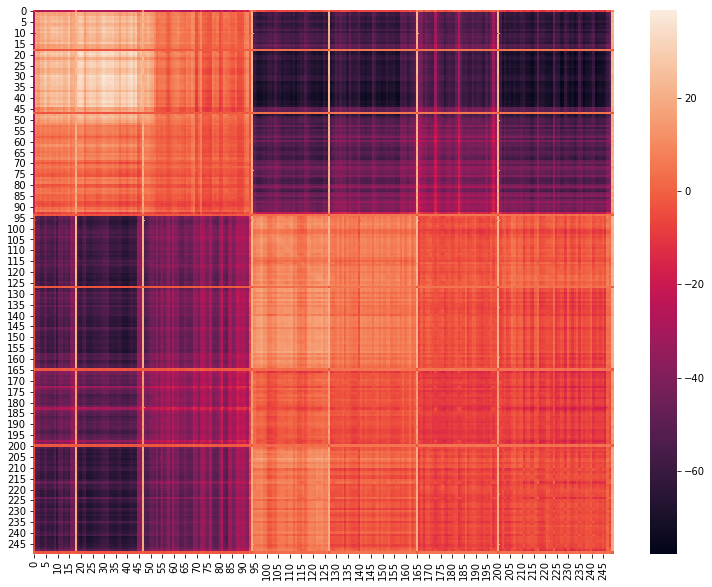

In [138]:
layer = 11

q, k = qs[layer], ks[layer]
new_q_shape = q.size()[:-1] + (8, 96)
new_k_shape = k.size()[:-1] + (8, 96)

q = q.view(*new_q_shape).permute(0, 2, 1, 3)
k = k.view(*new_k_shape).permute(0, 2, 1, 3)

attn_map = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(8)
attn_map = attn_map.detach().numpy()

head = 1
attn_map_head = np.mean(attn_map.squeeze(0), axis=0)

#sns.set_theme()
plt.figure(figsize=(13, 10))
sns.heatmap(attn_map_head)

In [94]:
src.shape

torch.Size([1, 123])

In [92]:
clss

tensor([[ 0, 13, 28, 50, 76, 98]])

In [956]:
i = 300
torch.matmul(q.squeeze(0)[0][i], k.squeeze(0)[0][i])

tensor(17.8544, grad_fn=<DotBackward>)

In [932]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 435, 96])

In [835]:
src[:, 127].item()

4531

In [806]:
print(*doc)

대한민국 제13대 대통령을 지낸 노태우 전 대통령이 26일 숨졌다.
지병으로 오랜 병상 생활을 해온 노 전 대통령은 최근 병세 악화로 끝내 회복하지 못하고 삶을 마감했다.
노 전 대통령은 경북고와 육군사관학교를 졸업하고 보안사령관, 체육부·내무부 장관, 12대 국회의원, 민주정의당 대표를 지냈다.
한국체육대학교(총장 안용규), 숙명여자대학교(총장 장윤금) 및 한국스포츠정책과학원(원장 남윤신)은 ‘스포츠 ODA(공적개발원조) 전문인력 양성을 위한 콜로키엄’을 개최한다.
콜로키엄은 온·오프라인으로 동시 운영되며, 전 과정이 한국체육대학교 유튜브 채널를 통해 중계된다.
이번 콜로키엄은 청소년과 여성의 역량강화를 통한 스포츠 ODA 방안을 모색하고, 저개발국가의 스포츠 전문인력 양성의 토대를 마련해 스포츠의 가치를 확산한다는 취지로 열린다.


### vocab

In [837]:
def get_kobert_vocab(cachedir="./tmp/"):
    # Add BOS,EOS vocab
    vocab_info = tokenizer
    vocab_file = _download(
        vocab_info["url"], vocab_info["fname"], vocab_info["chksum"], cachedir=cachedir
    )

    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(
        vocab_file, padding_token="[PAD]", bos_token="[BOS]", eos_token="[EOS]"
    )

    return vocab_b_obj

vocab = get_kobert_vocab(cachedir=args.temp_dir)
tokenizer = nlp.data.BERTSPTokenizer(get_tokenizer(), vocab, lower=False)

using cached model
using cached model


In [838]:
vocab.idx_to_token[4531]

'▁최소'

In [629]:
x = result_set[0].output[0]
new_x_shape = x.size()[:-1] + (8, 96)
x = x.view(*new_x_shape)
x = x.permute(1, 0, 2)

# etc

In [38]:
model.state_dict()['bert.model.embeddings.token_type_embeddings.weight']

tensor([[-0.0065,  0.0041,  0.0002,  ..., -0.0033,  0.0017, -0.0054],
        [ 0.0068, -0.0026, -0.0013,  ...,  0.0008, -0.0010,  0.0091]])

In [35]:
model.state_dict()

OrderedDict([('bert.model.embeddings.position_ids',
              tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
                  

In [ ]:
def transpose_for_scores(self, x):
    new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [ ]:
query_layer = self.transpose_for_scores(mixed_query_layer)
key_layer = self.transpose_for_scores(mixed_key_layer)
value_layer = self.transpose_for_scores(mixed_value_layer)

# Take the dot product between "query" and "key" to get the raw attention scores.
attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
attention_scores = attention_scores / math.sqrt(self.attention_head_size)

# Sep(Qual)

In [4]:
import torch

In [140]:
torch.sigmoid(torch.tensor([1.80]))

tensor([0.8581])

In [5]:
eval_set = torch.load('dataset/bfly/eval_data/eval_set.pt')

In [139]:
idx = 527
for i in eval_set[idx][0]:
    print(i)

올해산 노지감귤 출하 초기부터 비상품이 버젓이 유통, 제주 이미지를 흐리고 있다.
특히 비상품 감귤의 유통은 가격 하락 우려를 높이고, 선량한 농민에게 피해를 줄 수 있어 근절 대책이 시급해지고 있다.
22일 제주특별자치도감귤출하연합회에 따르면 노지감귤 10월 평균 경락가격은 7954원(5㎏ 기준)으로 지난해 같은 기간 9213원보다 14% 하락한 상황이다.
이런 가운데 제주도는 최근 전국 소비지 도매시장 유통 현장을 점검한 결과 7개 지역에서 16건, 2675㎏의 비상품 감귤 유통 행위를 적발했다.
이번 점검은 감귤 유통 지도 특별 점검반을 구성한 후 지난 17일부터 19일까지 사흘간 이뤄졌다.
이번에 적발된 비상품은 서울 송파구 가락시장에서 1건(50㎏), 부산 사상구 엄궁전통시장에서 2건(80㎏), 인천 남동구 구월농축산물도매시장에서 9건(2155㎏), 대구 북부농수산물도매시장에서 3건(340㎏), 광주 각화농산물도매시장 1건(50㎏) 등이다.
이들 비상품은 상품 규격보다 크기가 작거나 큰 것으로 품질이 낮은 것이다.
제주도는 이에 따라 이번에 적발된 감귤 유통업체에 대해 과태료를 부과하는 등 행정 절차를 이행할 계획이다.
앞으로 적발된 감귤 유통업체는 명단 관리를 통해 제주도나 양 행정시, 농업기술원 등에서 추진하는 농업분야 전 사업의 지원 대상에서 제외되는 페널티가 부여된다.
특히 2회 이상 적발된 선과장은 품질검사원을 해촉하고, 재위촉을 금지해 사실상 선과장 운영이 불가능하도록 강력 조치할 예정이다.
이와 관련, 제주도 관계자는 "올해 경기 침체와 감귤 외 다른 과일 생산량이 증가하며 감귤 경쟁력이 떨어질 수 있어 철저한 품질 관리 유통이 중요하다"며 "앞으로도 전국 소비지 감귤 출하 상태 모니터링을 강화하고 수시로 감귤유통지도 특별 점검반을 구성해 전국의 감귤출하 상황을 살펴 가격 안정화를 도모하겠다"고 밝혔다.
네이버가 클로바 인공지능 기술을 활용해 사용자 손글씨 109개를 '나눔손글씨' 글꼴로 제작한다.
제작된 글꼴은 한글날을 기념해 무료로 배